## imports and setting up the environment

In [1]:
import pyannote

# database related imports
from pyannote.database import registry, FileFinder

# training related imports
from pyannote.audio import Pipeline, Model
from pyannote.audio import pipelines
from pyannote.audio.tasks import SpeakerDiarization
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)
from types import MethodType
from torch.optim import Adam

# metrics related imports
from pyannote.metrics.diarization import DiarizationErrorRate

# other
import os

huggingface_token = os.getenv("HUGGINGFACE_TOKEN")


C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


## Data preparation

In [2]:
registry.load_database("database.yml")

protocol = registry.get_protocol("BP.SpeakerDiarization.VlaamseAudio", {"audio":FileFinder()})

for file in protocol.train():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)

for file in protocol.test():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)

for file in protocol.development():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)


C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyannote\database\registry.py:499: UserWarning: Replacing existing BP.SpeakerDiarization.VlaamseAudio protocol by the one defined in 'C:\Users\verho\Documents\School\2024-2025\Bacherlorproef\bp-stemmen-onderscheiden\pyannote\database.yml'.
  warnings.warn(


In [3]:
database = registry.get_database("BP")

database.get_tasks()

['SpeakerDiarization']

## pretrained pyannote pipeline

In [4]:
# get the model from the pipeline
pretrained_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=huggingface_token)


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\inspect.py:1007: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):


current error rate of the pipeline (possibly very slow)

In [5]:
metric = DiarizationErrorRate()

for file in protocol.test():
    print(file)
    file["pretrained pipeline"] = pretrained_pipeline(file)
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  std = sequences.std(dim=-1, correction=1)


Diarization error rate is 10.3% for the pretrained model


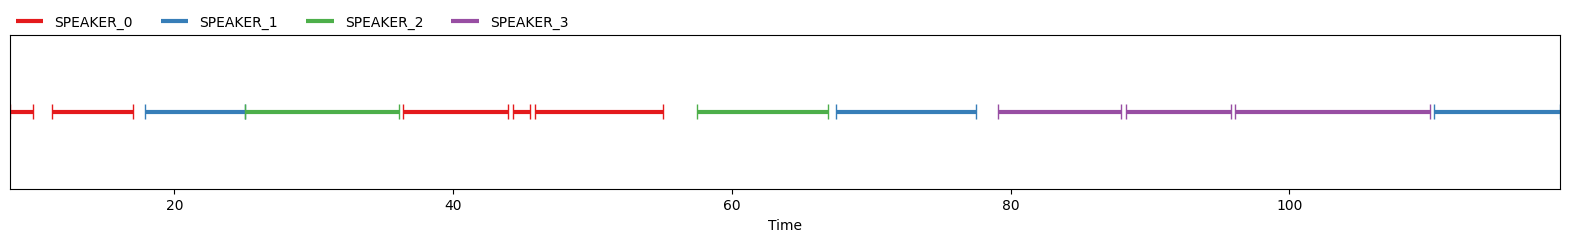

In [7]:
file["pretrained pipeline"]

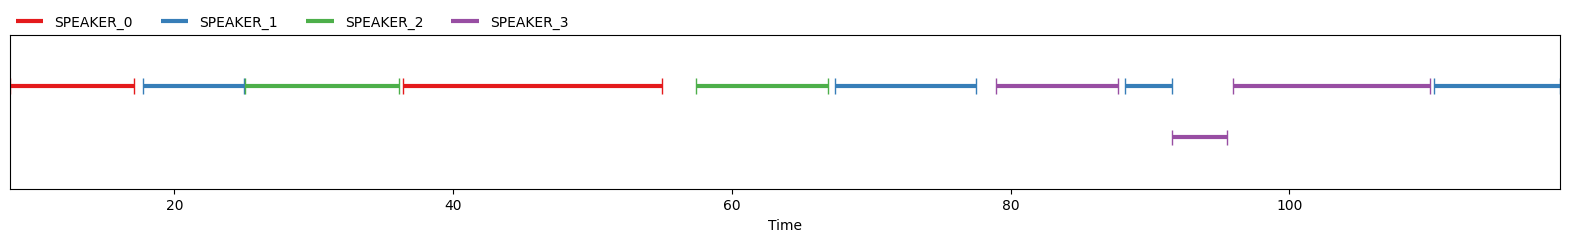

In [8]:
file["annotation"]

## train the model

In [7]:
import pyannote.audio
import pyannote.audio.tasks


pretrained_segm_model = Model.from_pretrained("pyannote/segmentation", use_auth_token=huggingface_token)
output_dir = "./models"

task = pyannote.audio.tasks.Segmentation(
    protocol,
    batch_size=32,
    vad_loss="bce"
)

task

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/660b9e20307a2b0cdb400d0f80aadc04a701fc54/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.6.0+cu124. Bad things might happen unless you revert torch to 1.x.


In [8]:
pretrained_segm_model.task = task
# pretrained_segm_model.task.prepare_data()
pretrained_segm_model.prepare_data()
pretrained_segm_model.setup()

/home/vicuser/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

   -   6.33% of all chunks contain no speech at all.
   -  82.41% contain 1 speaker or less
   -  98.73% contain 2 speakers or less
   - 100.00% contain 3 speakers or less
Setting `max_speakers_per_chunk` to 2. You can override this value (or avoid this estimation step) by passing `max_speakers_per_chunk=2` to the task constructor.


/home/vicuser/.local/lib/python3.10/site-packages/pyannote/audio/core/model.py:229: UserWarning: Model has been trained for a different task. For fine tuning or transfer learning, it is recommended to train task-dependent layers for a few epochs before training the whole model: ['activation', 'classifier'].
  warnings.warn(msg)


In [18]:
pretrained_segm_model.val_dataloader()

In [19]:
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)


In [20]:
pretrained_segm_model.configure_optimizers = MethodType(configure_optimizers, pretrained_segm_model)

In [22]:
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False
)

In [23]:
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False
)

In [24]:
callbacks = [RichProgressBar(), checkpoint, early_stopping]

In [25]:
trainer = pl.Trainer(
    callbacks=callbacks,
    max_epochs=10,
    gradient_clip_val=0.5
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(pretrained_segm_model)

┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃      In sizes ┃                           Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ train │ [1, 1, 32000] │                        [1, 60, 115] │
│ 1 │ lstm              │ LSTM             │  1.4 M │ train │  [1, 115, 60] │   [[1, 115, 256], [[8, 1, 128], [8, │
│   │                   │                  │        │       │               │                           1, 128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │ train │             ? │                                   ? │
│ 3 │ classifier        │ Linear           │    258 │ train │ [1, 115, 128] │                         [1, 115, 2] │
│ 4 │ activation        │ Sigmoid          │      0 │ train │   [1, 115, 2] │                         [1, 115, 2] │
│ 5 │ validation_metric │ MetricCollection │      0 │ train │             ? │                                   ? │
└───┴───────────────────┴──────────────────┴────────┴───────┴───────────────┴─────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0

TypeError: An invalid dataloader was returned from `PyanNet.val_dataloader()`. Found None.

In [59]:
trained_model = checkpoint.best_model_path

In [60]:
trained_model

'/home/vicuser/bp-stemmen-onderscheiden/pyannote/DiarizationErrorRate/epoch=9-v2.ckpt'

TODO: add finetuning

getrainde model terug in aan de pipeline toevoegen

In [61]:
from pyannote.audio import pipelines
finetuned_pipeline = pipelines.SpeakerDiarization(
    segmentation=trained_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

TODO: instantiate after finetuning [github notebook](https://github.com/pyannote/pyannote-audio/blob/main/tutorials/adapting_pretrained_pipeline.ipynb)

In [62]:
finetuned_pipeline.instantiate(
    pretrained_pipeline.parameters(),
)

test result of trained pipeline

In [63]:
metric = DiarizationErrorRate()

In [64]:
for file in protocol.test():
    file["finetuned pipeline"] = finetuned_pipeline(file)
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])
print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")


print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

RuntimeError: A pipeline must be instantiated with `pipeline.instantiate(parameters)` before it can be applied.